    Direct_Tilted  Diffuse_Tilted  Reflected_Tilted
0        0.000000        0.000000          0.000000
1        0.000000        0.000000          0.000000
2        0.000000        0.000000          0.000000
3        0.000000        0.000000          0.000000
4        0.000000        0.000000          0.000000
5        0.000000        0.000000          0.000000
6        0.000000        0.000000          0.000000
7        0.000000        0.000000          0.000000
8       57.274091       50.359650          1.523045
9      169.289210      115.229708          4.364109
10     264.618461      171.564232          7.175884
11     331.893499      163.882251          9.841212


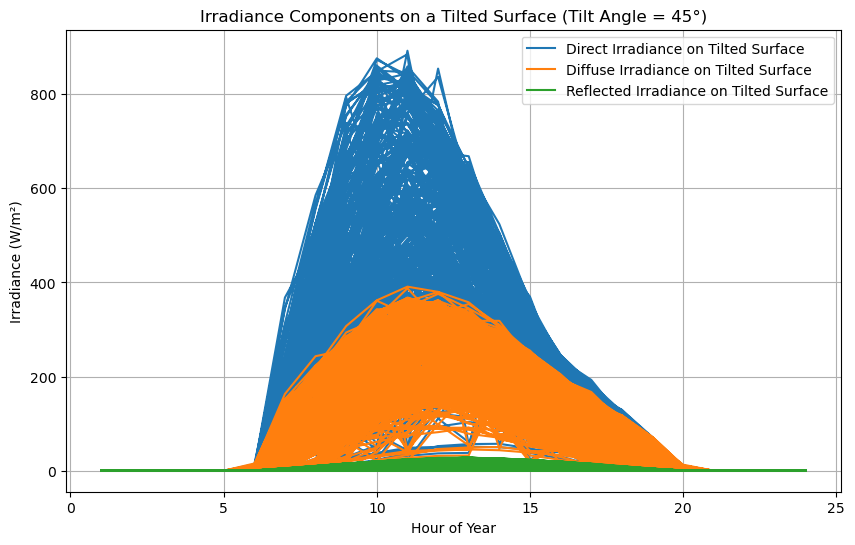

In [129]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 加载 CSV 数据
file_path = '3hour.csv'
# 指定列名
headers = ["year", "month", "day", "day_of_year", "hour_of_year", "global_direct", "global_diffuse", "global_horizontal",
           "solar_height", "tilted_direct", "tilted_diffuse", "tilted_global"]
cleaned_data = pd.read_csv(file_path, skiprows=4, names=headers)
# 删除空值行
cleaned_data = cleaned_data.dropna()  

# 所有列（除年份外）应为数值型
numeric_columns = headers[1:]  
cleaned_data[numeric_columns] = cleaned_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# 地区纬度设置 (石家庄: 38.033°)
latitude = 38.033

# 计算太阳赤纬角函数
def declination_angle(day_of_year):
    """基于一年中的天数计算太阳赤纬角（δ）。"""
    return 23.45 * np.sin(np.radians(360 / 365 * (day_of_year - 81)))

# 计算小时角函数
def hour_angle(hour):
    """基于一天中的小时计算小时角（ω）。"""
    return 15 * (hour - 12)

# 计算天顶角函数
def zenith_angle(latitude, declination, hour_angle):
    """
    计算太阳天顶角（θz）。
    θz = cos⁻¹(sin(φ)sin(δ) + cos(φ)cos(δ)cos(ω))
    """
    return np.degrees(
        np.arccos(
            np.sin(np.radians(latitude)) * np.sin(np.radians(declination)) +
            np.cos(np.radians(latitude)) * np.cos(np.radians(declination)) * np.cos(np.radians(hour_angle))
        )
    )

cleaned_data['Day_of_Year'] = cleaned_data['day_of_year']
# 假设斜面倾角为 45°
tilt_angle = 45

# 计算太阳赤纬角（δ）
cleaned_data['Declination'] = cleaned_data['Day_of_Year'].apply(declination_angle)

# 计算小时角（ω）
cleaned_data['Hour_Angle'] = cleaned_data['hour_of_year'].apply(hour_angle)

# 计算天顶角（θz）
cleaned_data['Zenith_Angle'] = zenith_angle(
    latitude, cleaned_data['Declination'], cleaned_data['Hour_Angle']
)

def direct_irradiance_on_tilted_surface(global_direct, solar_height, tilt_angle):
    """
    计算直射辐照量在斜面上的分量。
    使用公式：I_b = I_bh * cos(θz - tilt_angle)
    """
    return global_direct * np.cos(np.radians(solar_height - tilt_angle))

def diffuse_irradiance_on_tilted_surface(global_diffuse, tilt_angle):
    """
    计算散射辐照量在斜面上的分量。
    使用公式：I_d = I_dh * (1 + cos(tilt_angle)) / 2
    """
    return global_diffuse * (1 + np.cos(np.radians(tilt_angle))) / 2

def reflected_irradiance_on_tilted_surface(tilted_global, tilt_angle, albedo=0.2):
    """
    计算反射辐照量在斜面上的分量。
    使用公式：I_r = I_h * ρ * (1 - cos(tilt_angle)) / 2
    其中 ρ 为地表反射率，默认 0.2。
    """
    return tilted_global * albedo * (1 - np.cos(np.radians(tilt_angle))) / 2


# 计算斜面上的直射辐照量
cleaned_data['Direct_Tilted'] = direct_irradiance_on_tilted_surface(
    cleaned_data['global_direct'], cleaned_data['solar_height'], tilt_angle
)

# 计算斜面上的散射辐照量
cleaned_data['Diffuse_Tilted'] = diffuse_irradiance_on_tilted_surface(
    cleaned_data['global_diffuse'], tilt_angle
)

# 计算斜面上的反射辐照量
cleaned_data['Reflected_Tilted'] = reflected_irradiance_on_tilted_surface(
    cleaned_data['tilted_global'], tilt_angle
)

# 显示结果前几行
print(cleaned_data[['Direct_Tilted', 'Diffuse_Tilted', 'Reflected_Tilted']].head(12))
# 可视化斜面辐照量
import matplotlib.pyplot as pl

# 绘制直射辐照量
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data['hour_of_year'], cleaned_data['Direct_Tilted'], label='Direct Irradiance on Tilted Surface')
plt.plot(cleaned_data['hour_of_year'], cleaned_data['Diffuse_Tilted'], label='Diffuse Irradiance on Tilted Surface')
plt.plot(cleaned_data['hour_of_year'], cleaned_data['Reflected_Tilted'], label='Reflected Irradiance on Tilted Surface')
plt.xlabel('Hour of Year')
plt.ylabel('Irradiance (W/m²)')
plt.title('Irradiance Components on a Tilted Surface (Tilt Angle = 45°)')
plt.legend()
plt.grid()
plt.show()


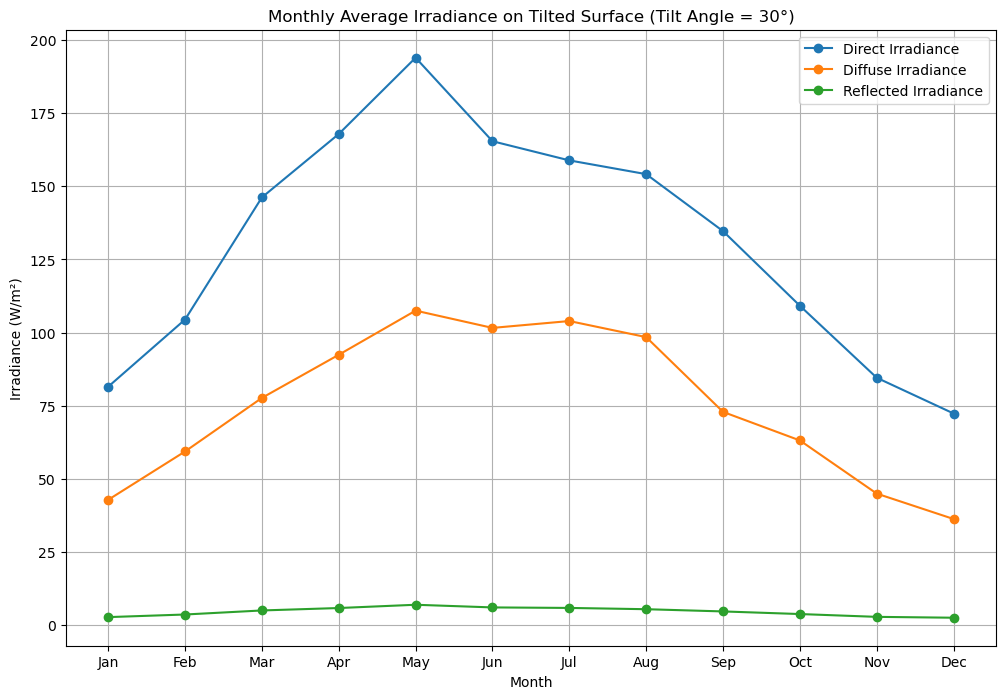

In [121]:
import matplotlib.pyplot as plt

# 按月份分组，并计算每月的平均值
monthly_data = cleaned_data.groupby('month').mean()

# 创建图形并绘制每种辐照量的变化
plt.figure(figsize=(12, 8))

# 绘制直射辐照量
plt.plot(monthly_data.index, monthly_data['Direct_Tilted'], label='Direct Irradiance', marker='o')

# 绘制散射辐照量
plt.plot(monthly_data.index, monthly_data['Diffuse_Tilted'], label='Diffuse Irradiance', marker='o')

# 绘制反射辐照量
plt.plot(monthly_data.index, monthly_data['Reflected_Tilted'], label='Reflected Irradiance', marker='o')

# 设置图表样式
plt.xlabel('Month')  # X轴标签
plt.ylabel('Irradiance (W/m²)')  # Y轴标签
plt.title('Monthly Average Irradiance on Tilted Surface (Tilt Angle = 45°)')  # 图标题
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # X轴刻度
plt.grid()  # 添加网格
plt.legend()  # 添加图例
plt.show()  # 显示图表


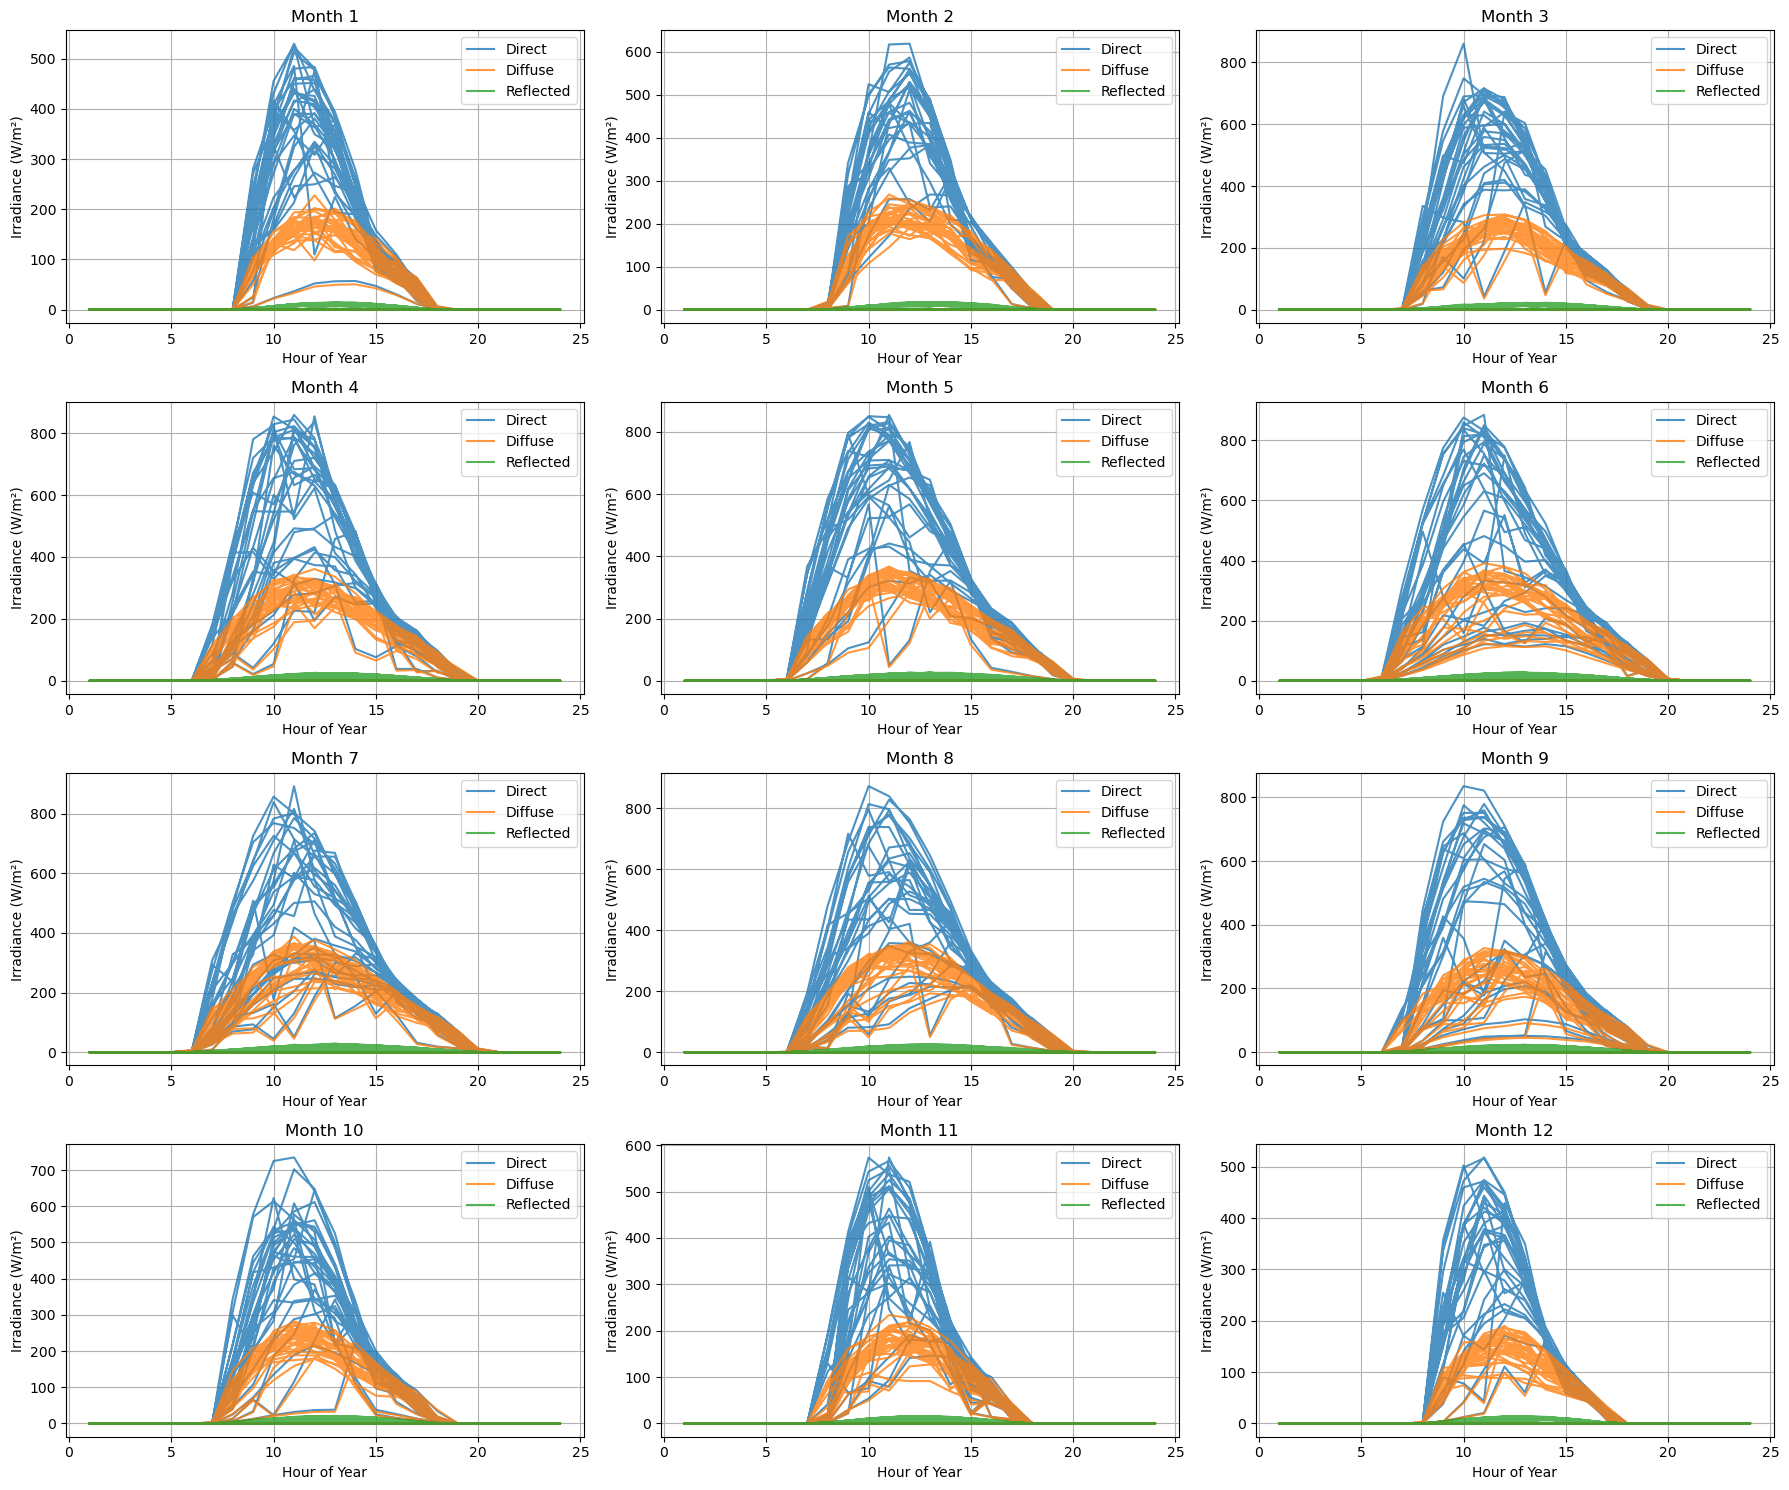

In [123]:
import matplotlib.pyplot as plt

# 获取所有月份的唯一值
months = cleaned_data['month'].unique()

# 创建一个多图布局，每个子图表示一个月
plt.figure(figsize=(18, 15))

for i, month in enumerate(sorted(months), 1):
    # 筛选当前月的数据
    monthly_data = cleaned_data[cleaned_data['month'] == month]
    
    # 创建子图
    plt.subplot(4, 3, i)
    
    # 绘制当前月的三种辐照量
    plt.plot(monthly_data['hour_of_year'], monthly_data['Direct_Tilted'], label='Direct', alpha=0.8)
    plt.plot(monthly_data['hour_of_year'], monthly_data['Diffuse_Tilted'], label='Diffuse', alpha=0.8)
    plt.plot(monthly_data['hour_of_year'], monthly_data['Reflected_Tilted'], label='Reflected', alpha=0.8)
    
    # 添加标题和标签
    plt.title(f'Month {month}')
    plt.xlabel('Hour of Year')
    plt.ylabel('Irradiance (W/m²)')
    plt.grid()
    plt.legend()

# 调整布局
plt.tight_layout()
plt.show()
